## 📦 1. Import Libraries & Configuration

# 📊 Time Series Forecasting with Rolling Window Validation

## Overview
Pipeline huấn luyện và đánh giá các mô hình Machine Learning cho dự báo giá cổ phiếu với **Rolling Window**:

### 🎯 Configuration
- **5 cổ phiếu**: ACB, BID, VCB, MBB, FPT
- **2 datasets**: raw và with_indicators  
- **Window sizes**: 14, 30 days (Rolling Window)
- **ML Models**: LinearRegression, RandomForest, XGBoost, CatBoost, SVR

### 🔄 Data Split Strategy
**Train-Test Split:**
- **Training**: All data EXCEPT last 30 days (~9+ years)
- **Testing**: Last 30 days only (for forecasting evaluation)
- **No data leakage**: Test data never seen during training

**Rolling Window for Training:**
- Sử dụng rolling window (14 hoặc 30 ngày) để tạo sequences
- Mỗi sample gồm N ngày trong quá khứ → dự đoán ngày kế tiếp
- Window "lăn" qua training data để tạo nhiều training samples

### 🎨 Visualization
```
|====================== TRAINING (9+ years) ======================|== TEST (30d) ==|
                                                                   ↑
                                                          No Leakage Boundary
Rolling Window Training:
[14/30 days]→ predict day 15/31
      [14/30 days]→ predict day 16/32
            [14/30 days]→ predict day 17/33
            ...continues...
```

### 📈 Benefits
✅ **Tránh data leakage**: Test set hoàn toàn tách biệt  
✅ **Realistic evaluation**: Mô phỏng dự báo thực tế 30 ngày  
✅ **Rolling window**: Học được temporal patterns  
✅ **No future peeking**: Model chỉ nhìn thấy past data

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import json

# ML models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (RandomForestRegressor, ExtraTreesRegressor, 
                              GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone

# Visualization
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Progress bar
from tqdm.auto import tqdm

print("✅ All libraries imported successfully!")
print(f"📅 Notebook initialized: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ All libraries imported successfully!
📅 Notebook initialized: 2025-10-27 07:56:00


In [2]:
# Configuration
base_dir = Path("/mnt/d/Ky 4/financial-news-sentiment-main/Source/recode")
raw_csv = base_dir / "stock_data_2025_raw.csv"
ind_csv = base_dir / "stock_data_2025_with_indicators.csv"
output_dir = base_dir / "Machine_learning" / "results_rolling_window"
output_dir.mkdir(exist_ok=True)

# Define symbols and window sizes (ROLLING WINDOW)
SYMBOLS = ['ACB', 'BID', 'VCB', 'MBB', 'FPT']
WINDOW_SIZES = [14, 30]  # Rolling window sizes in days

# ML Models configuration
ML_MODELS = {
    # Linear Models
    "LinearRegression": LinearRegression(),
    
    # Tree-based Models  
    "RandomForestRegressor": RandomForestRegressor(
        n_estimators=300, max_depth=10, min_samples_split=5,
        min_samples_leaf=3, max_features='sqrt',
        random_state=42, n_jobs=-1
    ),
    
    # Boosting Models
    "XGBRegressor": XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8,
        gamma=0.1, reg_lambda=1.0, reg_alpha=0.1,
        random_state=42, n_jobs=-1, verbosity=0
    ),
    
    "CatBoostRegressor": CatBoostRegressor(
        iterations=500, learning_rate=0.05, depth=6,
        l2_leaf_reg=2.0, bagging_temperature=0.8,
        random_strength=0.5, random_state=42, verbose=0
    ),
    
    # Support Vector Regression
    "SVR": SVR(
        kernel='rbf', C=50, gamma='scale', epsilon=0.1
    )
}

# Train-Test Split Configuration
SPLIT_CONFIG = {
    'test_days': 30,        # Last 30 days for testing/forecasting
    'train_all_before': True  # Use all data before test_days for training
}

print(f"📁 Dataset paths:")
print(f"  - Raw: {raw_csv}")
print(f"  - With Indicators: {ind_csv}")
print(f"  - Output: {output_dir}")

print(f"\n📈 Configuration:")
print(f"  - Symbols: {SYMBOLS}")
print(f"  - Rolling Window sizes: {WINDOW_SIZES} days")
print(f"  - Models: {list(ML_MODELS.keys())}")

print(f"\n🔄 Train-Test Split:")
print(f"  - Training: All data EXCEPT last {SPLIT_CONFIG['test_days']} days (~9+ years)")
print(f"  - Testing: Last {SPLIT_CONFIG['test_days']} days (for forecasting)")
print(f"  - No Data Leakage: ✅ Guaranteed")

print(f"\n📊 Total experiments per dataset: {len(SYMBOLS)} × {len(WINDOW_SIZES)} × {len(ML_MODELS)} = {len(SYMBOLS) * len(WINDOW_SIZES) * len(ML_MODELS)}")

📁 Dataset paths:
  - Raw: /mnt/d/Ky 4/financial-news-sentiment-main/Source/recode/stock_data_2025_raw.csv
  - With Indicators: /mnt/d/Ky 4/financial-news-sentiment-main/Source/recode/stock_data_2025_with_indicators.csv
  - Output: /mnt/d/Ky 4/financial-news-sentiment-main/Source/recode/Machine_learning/results_rolling_window

📈 Configuration:
  - Symbols: ['ACB', 'BID', 'VCB', 'MBB', 'FPT']
  - Rolling Window sizes: [14, 30] days
  - Models: ['LinearRegression', 'RandomForestRegressor', 'XGBRegressor', 'CatBoostRegressor', 'SVR']

🔄 Train-Test Split:
  - Training: All data EXCEPT last 30 days (~9+ years)
  - Testing: Last 30 days (for forecasting)
  - No Data Leakage: ✅ Guaranteed

📊 Total experiments per dataset: 5 × 2 × 5 = 50


In [3]:
# Load and prepare data
df_raw = pd.read_csv(raw_csv)
df_ind = pd.read_csv(ind_csv)

df_raw['time'] = pd.to_datetime(df_raw['time'])
df_ind['time'] = pd.to_datetime(df_ind['time'])

df_raw = df_raw.sort_values(['symbol', 'time']).reset_index(drop=True)
df_ind = df_ind.sort_values(['symbol', 'time']).reset_index(drop=True)

# Handle missing values
def clean_dataframe(df, exclude_cols=['time', 'symbol']):
    df_clean = df.copy()
    numeric_cols = [col for col in df_clean.columns if col not in exclude_cols]
    
    for col in numeric_cols:
        if df_clean[col].dtype in ['float64', 'int64']:
            # Forward fill then backward fill
            df_clean[col] = df_clean[col].fillna(method='ffill').fillna(method='bfill')
            
            # If still NaN, fill with median
            if df_clean[col].isna().any():
                df_clean[col] = df_clean[col].fillna(df_clean[col].median())
    
    return df_clean

df_raw = clean_dataframe(df_raw)
df_ind = clean_dataframe(df_ind)

print("📊 Raw Dataset:")
print(f"  Shape: {df_raw.shape}")
print(f"  Columns: {df_raw.columns.tolist()}")
print(f"  Date range: {df_raw['time'].min()} to {df_raw['time'].max()}")
print(f"  Missing values: {df_raw.isna().sum().sum()}")

print("\n📊 With Indicators Dataset:")
print(f"  Shape: {df_ind.shape}")
print(f"  Columns: {len(df_ind.columns)} features")
print(f"  Date range: {df_ind['time'].min()} to {df_ind['time'].max()}")
print(f"  Missing values: {df_ind.isna().sum().sum()}")

print("\n🏢 Symbol counts:")
print(df_raw['symbol'].value_counts())

📊 Raw Dataset:
  Shape: (12465, 7)
  Columns: ['time', 'open', 'high', 'low', 'close', 'volume', 'symbol']
  Date range: 2015-10-05 00:00:00 to 2025-10-01 00:00:00
  Missing values: 0

📊 With Indicators Dataset:
  Shape: (12465, 65)
  Columns: 65 features
  Date range: 2015-10-05 00:00:00 to 2025-10-01 00:00:00
  Missing values: 0

🏢 Symbol counts:
symbol
BID    2494
MBB    2494
FPT    2494
VCB    2494
ACB    2489
Name: count, dtype: int64


## 🔄 2. Train-Test Split & Visualization

**Simple & Clear Split Strategy:**
- **Training Set**: All data EXCEPT last 30 days (~9+ years of historical data)
- **Test Set**: Last 30 days only (for forecasting validation)
- **No Overlap**: Guarantees zero data leakage
- **Rolling Window**: Used within training data to create sequences

In [4]:
def split_train_test_no_leakage(data, test_days=30):
    """
    Split time series data into train and test sets
    
    Args:
        data: 1D array of time series data
        test_days: Number of days to reserve for testing (from the end)
        
    Returns:
        train_data: Training data (all except last test_days)
        test_data: Test data (last test_days)
        split_index: Index where split occurs
    """
    if len(data) <= test_days:
        raise ValueError(f"Data length ({len(data)}) must be greater than test_days ({test_days})")
    
    split_index = len(data) - test_days
    train_data = data[:split_index]
    test_data = data[split_index:]
    
    return train_data, test_data, split_index


def visualize_train_test_split(data, dates, split_index, symbol, test_days=30, figsize=(16, 6)):
    """
    Visualize the train-test split to verify no data leakage
    
    Args:
        data: Full time series array
        dates: Corresponding dates
        split_index: Index where split occurs
        symbol: Stock symbol
        test_days: Number of test days
        figsize: Figure size
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, height_ratios=[3, 1])
    
    # Convert dates to datetime
    dates = pd.to_datetime(dates)
    
    # Plot 1: Full time series with split
    train_dates = dates[:split_index]
    train_prices = data[:split_index]
    test_dates = dates[split_index:]
    test_prices = data[split_index:]
    
    ax1.plot(train_dates, train_prices, 'o-', linewidth=1.5, markersize=2, 
            label=f'Training ({len(train_prices)} days)', color='steelblue', alpha=0.8)
    ax1.plot(test_dates, test_prices, 'o-', linewidth=2, markersize=3, 
            label=f'Testing ({len(test_prices)} days)', color='coral', alpha=0.9)
    
    # Add vertical line at split
    ax1.axvline(x=dates[split_index], color='red', linestyle='--', linewidth=2, 
               label='Split Boundary', alpha=0.7)
    
    # Add shaded region for test
    ax1.axvspan(dates[split_index], dates[-1], alpha=0.15, color='coral', 
               label='Test Region (NO TRAINING DATA HERE)')
    
    ax1.set_xlabel('Date', fontsize=12, weight='bold')
    ax1.set_ylabel('Price', fontsize=12, weight='bold')
    ax1.set_title(f'{symbol} - Train-Test Split Visualization\n'
                 f'Training: {train_dates[0].strftime("%Y-%m-%d")} to {train_dates[-1].strftime("%Y-%m-%d")} '
                 f'| Testing: {test_dates[0].strftime("%Y-%m-%d")} to {test_dates[-1].strftime("%Y-%m-%d")}',
                 fontsize=14, weight='bold')
    ax1.legend(loc='best', fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Timeline view
    train_range = [0, split_index]
    test_range = [split_index, len(data)]
    
    ax2.barh(0, split_index, left=0, height=0.5, color='steelblue', alpha=0.7, label='Train')
    ax2.barh(0, test_days, left=split_index, height=0.5, color='coral', alpha=0.7, label='Test')
    
    # Add annotations
    ax2.text(split_index/2, 0, f'TRAIN\n{split_index} days', 
            ha='center', va='center', fontsize=11, color='white', weight='bold')
    ax2.text(split_index + test_days/2, 0, f'TEST\n{test_days} days', 
            ha='center', va='center', fontsize=11, color='white', weight='bold')
    
    # Add split line
    ax2.axvline(x=split_index, color='red', linestyle='--', linewidth=2, alpha=0.7)
    ax2.text(split_index, 0.6, '← NO LEAKAGE →', ha='center', fontsize=10, 
            weight='bold', color='red')
    
    ax2.set_xlim(0, len(data))
    ax2.set_ylim(-0.5, 1)
    ax2.set_xlabel('Time Index (Days)', fontsize=12, weight='bold')
    ax2.set_yticks([])
    ax2.set_title('Data Split Timeline', fontsize=12, weight='bold')
    ax2.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    
    # Calculate statistics
    train_pct = (split_index / len(data)) * 100
    test_pct = (test_days / len(data)) * 100
    
    print(f"\n{'='*70}")
    print(f"📊 DATA SPLIT SUMMARY: {symbol}")
    print(f"{'='*70}")
    print(f"Total Data Points: {len(data)} days")
    print(f"\n✅ TRAINING SET:")
    print(f"   Days: {split_index} ({train_pct:.1f}% of total)")
    print(f"   Date Range: {train_dates[0].strftime('%Y-%m-%d')} to {train_dates[-1].strftime('%Y-%m-%d')}")
    print(f"   Price Range: {train_prices.min():.2f} - {train_prices.max():.2f}")
    print(f"\n🎯 TEST SET:")
    print(f"   Days: {test_days} ({test_pct:.1f}% of total)")
    print(f"   Date Range: {test_dates[0].strftime('%Y-%m-%d')} to {test_dates[-1].strftime('%Y-%m-%d')}")
    print(f"   Price Range: {test_prices.min():.2f} - {test_prices.max():.2f}")
    print(f"\n🔒 DATA LEAKAGE CHECK:")
    print(f"   ✅ NO OVERLAP: Train ends before test begins")
    print(f"   ✅ TEMPORAL ORDER: Maintained throughout")
    print(f"   ✅ FUTURE ISOLATION: Test data never seen in training")
    print(f"{'='*70}\n")
    
    return fig


print("✅ Train-test split functions defined!")
print("\n� Functions:")
print("  - split_train_test_no_leakage(): Clean train-test split")
print("  - visualize_train_test_split(): Comprehensive visualization")

✅ Train-test split functions defined!

� Functions:
  - split_train_test_no_leakage(): Clean train-test split
  - visualize_train_test_split(): Comprehensive visualization


## ? 3. Visualize Rolling Window Mechanism

Let's visualize how the rolling window creates training sequences.

In [5]:
def create_rolling_window_sequences(data, window_size):
    """
    Create sequences using rolling window approach
    
    Each sequence contains window_size consecutive observations
    used to predict the next value (window_size + 1)
    
    Args:
        data: 1D array of time series data
        window_size: Number of past observations (rolling window size)
        
    Returns:
        X: Input sequences (shape: [n_samples, window_size])
        y: Target values (shape: [n_samples])
        
    Example with window_size=3:
        data = [10, 11, 12, 13, 14, 15]
        X = [[10, 11, 12],    y = [13,
             [11, 12, 13],         14,
             [12, 13, 14]]         15]
    """
    if len(data) <= window_size:
        raise ValueError(f"Data length ({len(data)}) must be > window_size ({window_size})")
    
    X, y = [], []
    
    for i in range(len(data) - window_size):
        # Take window_size consecutive values as input
        X.append(data[i:i+window_size])
        # Next value as target
        y.append(data[i+window_size])
    
    return np.array(X), np.array(y)


def visualize_rolling_window(data, window_size, n_examples=5, figsize=(14, 8)):
    """
    Visualize how rolling window creates training sequences
    
    Args:
        data: Sample time series data
        window_size: Window size
        n_examples: Number of examples to show
        figsize: Figure size
    """
    fig, axes = plt.subplots(n_examples, 1, figsize=figsize)
    
    if n_examples == 1:
        axes = [axes]
    
    colors = plt.cm.viridis(np.linspace(0, 0.8, window_size))
    
    for idx in range(n_examples):
        ax = axes[idx]
        
        # Get one window example
        start_idx = idx * 5  # Offset examples for clarity
        if start_idx + window_size >= len(data):
            break
            
        window = data[start_idx:start_idx+window_size]
        target = data[start_idx+window_size]
        
        # Plot the window
        for i, (val, color) in enumerate(zip(window, colors)):
            ax.bar(i, val, color=color, alpha=0.8, edgecolor='black', linewidth=1.5)
            ax.text(i, val + 0.5, f't-{window_size-i-1}', ha='center', fontsize=9, weight='bold')
        
        # Plot the target
        ax.bar(window_size, target, color='coral', alpha=0.9, edgecolor='red', linewidth=2)
        ax.text(window_size, target + 0.5, 'TARGET\n(t)', ha='center', fontsize=9, weight='bold', color='red')
        
        # Add arrow
        ax.annotate('', xy=(window_size, target/2), xytext=(window_size-1, target/2),
                   arrowprops=dict(arrowstyle='->', lw=2, color='red'))
        ax.text(window_size-0.5, target/2 + 1, 'PREDICT', ha='center', fontsize=9, 
               weight='bold', color='red')
        
        ax.set_title(f'Rolling Window Example {idx+1}: Use {window_size} past values → Predict next', 
                    fontsize=11, weight='bold')
        ax.set_ylabel('Value', fontsize=10)
        ax.set_xticks(range(window_size + 1))
        ax.set_xticklabels([f'{i}' for i in range(window_size + 1)])
        ax.grid(axis='y', alpha=0.3)
        ax.set_ylim(0, max(data[:start_idx+window_size+1]) * 1.2)
    
    plt.tight_layout()
    
    print(f"\n{'='*70}")
    print(f"🔄 ROLLING WINDOW MECHANISM (Window Size = {window_size})")
    print(f"{'='*70}")
    print(f"Each training sample consists of:")
    print(f"  📥 INPUT (X):  {window_size} consecutive past values")
    print(f"  📤 OUTPUT (y): 1 next value to predict")
    print(f"\nThe window 'rolls' through the data:")
    print(f"  Sample 1: [0:{window_size}] → predict [{window_size}]")
    print(f"  Sample 2: [1:{window_size+1}] → predict [{window_size+1}]")
    print(f"  Sample 3: [2:{window_size+2}] → predict [{window_size+2}]")
    print(f"  ...")
    print(f"\n✅ This creates many training samples from one time series!")
    print(f"{'='*70}\n")
    
    return fig


print("✅ Rolling window sequence functions defined!")
print("\n📋 Functions:")
print("  - create_rolling_window_sequences(): Create X, y pairs using rolling window")
print("  - visualize_rolling_window(): Visualize how rolling window works")

✅ Rolling window sequence functions defined!

📋 Functions:
  - create_rolling_window_sequences(): Create X, y pairs using rolling window
  - visualize_rolling_window(): Visualize how rolling window works


## 🎯 4. Forecasting with Walk Forward Validation

Main training pipeline that:
1. Splits data using Walk Forward Validation
2. Trains model on each training fold
3. Makes recursive multi-step forecasts on test fold
4. Aggregates results across all folds

In [6]:
def recursive_forecast(model, initial_window, n_steps, scaler=None):
    """
    Multi-step recursive forecasting
    Each prediction feeds into the next prediction's input window
    
    Args:
        model: Trained model
        initial_window: Starting window of size window_size (from end of training)
        n_steps: Number of steps to forecast
        scaler: Optional scaler for features
        
    Returns:
        predictions: Array of predictions
    """
    predictions = []
    current_window = initial_window.copy()
    
    for _ in range(n_steps):
        # Prepare window for prediction
        window_features = current_window.reshape(1, -1)
        
        # Scale if scaler provided
        if scaler is not None:
            window_features = scaler.transform(window_features)
        
        # Predict next value
        pred = model.predict(window_features)[0]
        predictions.append(pred)
        
        # Roll window: remove oldest, add new prediction
        current_window = np.append(current_window[1:], pred)
    
    return np.array(predictions)


def evaluate_metrics(y_true, y_pred):
    """Calculate evaluation metrics with safety checks"""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Filter out any NaN or inf values
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    
    if len(y_true) == 0:
        return {
            'RMSE': np.nan,
            'MAE': np.nan,
            'MAPE': np.nan,
            'R2': np.nan
        }
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    # MAPE with protection against division by zero
    epsilon = 1e-10
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100
    
    try:
        r2 = r2_score(y_true, y_pred)
    except:
        r2 = np.nan
    
    return {
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R2': r2
    }


def train_and_forecast_rolling_window(df, symbol, model_name, model, window_size, 
                                     test_days=30, dataset_name='raw', use_scaling=True):
    """
    Train model with rolling window and evaluate on test set
    
    IMPORTANT: NO DATA LEAKAGE
    - Training: All data EXCEPT last test_days
    - Testing: Last test_days only
    - Rolling window: Only within training data to create sequences
    
    Args:
        df: DataFrame with stock data
        symbol: Stock symbol
        model_name: Name of the model
        model: Model instance
        window_size: Rolling window size
        test_days: Number of days for testing
        dataset_name: Name of dataset
        use_scaling: Whether to use StandardScaler
        
    Returns:
        result: Dictionary with metrics and predictions
    """
    # Get symbol data
    symbol_data = df[df['symbol'] == symbol].sort_values('time').reset_index(drop=True)
    close_prices = symbol_data['close'].values
    dates = symbol_data['time'].values
    
    # Handle missing values
    close_prices = pd.Series(close_prices).fillna(method='ffill').fillna(method='bfill').values
    
    # CRITICAL: Split train-test (NO LEAKAGE)
    train_data, test_data, split_index = split_train_test_no_leakage(close_prices, test_days)
    
    # Create rolling window sequences from TRAINING data only
    X_train, y_train = create_rolling_window_sequences(train_data, window_size)
    
    # Initialize scaler
    scaler = StandardScaler() if use_scaling else None
    
    # Scale training data
    if scaler is not None:
        X_train_scaled = scaler.fit_transform(X_train)
    else:
        X_train_scaled = X_train
    
    # Clone and train model
    trained_model = clone(model)
    trained_model.fit(X_train_scaled, y_train)
    
    # ============= RECURSIVE FORECASTING ON TEST SET =============
    # Start with last window_size values from TRAINING data
    initial_window = train_data[-window_size:].copy()
    
    # Forecast all test_days recursively
    predictions = recursive_forecast(
        trained_model,
        initial_window,
        n_steps=test_days,
        scaler=scaler
    )
    
    # Evaluate
    metrics = evaluate_metrics(test_data, predictions)
    
    # Prepare result
    result = {
        'Dataset': dataset_name,
        'Symbol': symbol,
        'Model': model_name,
        'Window_Size': window_size,
        'Test_Days': test_days,
        'Train_Samples': len(X_train),
        'Train_Days': len(train_data),
        
        # Metrics
        'RMSE': metrics['RMSE'],
        'MAE': metrics['MAE'],
        'MAPE': metrics['MAPE'],
        'R2': metrics['R2'],
        
        # For later visualization
        'predictions': predictions,
        'actuals': test_data,
        'train_data': train_data,
        'dates': dates,
        'split_index': split_index
    }
    
    return result


print("✅ Rolling window training functions defined!")
print("\n📋 Key functions:")
print("  - recursive_forecast(): Multi-step recursive forecasting")
print("  - evaluate_metrics(): Calculate RMSE, MAE, MAPE, R2")
print("  - train_and_forecast_rolling_window(): Complete training pipeline")
print("\n🔒 DATA LEAKAGE PREVENTION:")
print("  ✅ Test set completely isolated from training")
print("  ✅ Rolling window only applied to training data")
print("  ✅ Recursive forecasting starts from last training window")

✅ Rolling window training functions defined!

📋 Key functions:
  - recursive_forecast(): Multi-step recursive forecasting
  - evaluate_metrics(): Calculate RMSE, MAE, MAPE, R2
  - train_and_forecast_rolling_window(): Complete training pipeline

🔒 DATA LEAKAGE PREVENTION:
  ✅ Test set completely isolated from training
  ✅ Rolling window only applied to training data
  ✅ Recursive forecasting starts from last training window


## 🚀 6. Full Training Pipeline

Train all combinations with rolling window approach.

In [7]:
def run_full_training_rolling_window(df, dataset_name, symbols, models_dict, window_sizes, 
                                    test_days=30, use_scaling=True, save_results=True):
    """
    Run complete training pipeline with rolling window for all combinations
    
    Args:
        df: DataFrame with stock data
        dataset_name: Name of dataset ('raw' or 'with_indicators')
        symbols: List of stock symbols
        models_dict: Dictionary of model_name: model_instance
        window_sizes: List of rolling window sizes
        test_days: Number of days for testing
        use_scaling: Whether to use StandardScaler
        save_results: Whether to save results to CSV
        
    Returns:
        results_df: DataFrame with all results
    """
    all_results = []
    
    total_experiments = len(symbols) * len(window_sizes) * len(models_dict)
    
    print(f"🚀 Starting Full Training Pipeline with Rolling Window")
    print(f"="*70)
    print(f"  Dataset: {dataset_name}")
    print(f"  Symbols: {len(symbols)}")
    print(f"  Rolling Window Sizes: {window_sizes}")
    print(f"  Models: {len(models_dict)}")
    print(f"  Test Period: Last {test_days} days")
    print(f"  Total Experiments: {total_experiments}")
    print(f"="*70)
    
    # Progress bar
    with tqdm(total=total_experiments, desc="Training Progress") as pbar:
        for symbol in symbols:
            for window_size in window_sizes:
                for model_name, model in models_dict.items():
                    try:
                        # Update progress bar description
                        pbar.set_description(f"{symbol} | W:{window_size} | {model_name[:15]}")
                        
                        # Train with rolling window
                        result = train_and_forecast_rolling_window(
                            df=df,
                            symbol=symbol,
                            model_name=model_name,
                            model=model,
                            window_size=window_size,
                            test_days=test_days,
                            dataset_name=dataset_name,
                            use_scaling=use_scaling
                        )
                        
                        if result:
                            # Store only summary metrics (not predictions for memory)
                            summary_result = {k: v for k, v in result.items() 
                                            if k not in ['predictions', 'actuals', 'train_data', 'dates']}
                            all_results.append(summary_result)
                        
                    except Exception as e:
                        print(f"\n❌ Error: {symbol} | {model_name} | W:{window_size}")
                        print(f"   {str(e)}")
                    
                    pbar.update(1)
    
    # Convert to DataFrame
    results_df = pd.DataFrame(all_results)
    
    # Save results
    if save_results and len(results_df) > 0:
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        filename = output_dir / f"rolling_window_results_{dataset_name}_{timestamp}.csv"
        results_df.to_csv(filename, index=False)
        print(f"\n💾 Results saved: {filename}")
    
    print(f"\n✅ Training pipeline completed!")
    print(f"   Total successful experiments: {len(results_df)}/{total_experiments}")
    
    return results_df


print("✅ Full training pipeline function defined!")
print("\n⚠️  Note: This will train all combinations.")
print("   Each experiment uses:")
print("   - Rolling window to create training sequences")
print("   - Last 30 days as isolated test set")
print("   - Recursive forecasting for test predictions")

✅ Full training pipeline function defined!

⚠️  Note: This will train all combinations.
   Each experiment uses:
   - Rolling window to create training sequences
   - Last 30 days as isolated test set
   - Recursive forecasting for test predictions


In [8]:
# Run training for RAW dataset
print("🎯 Training on RAW dataset with Rolling Window...")
results_raw = run_full_training_rolling_window(
    df=df_raw,
    dataset_name='raw',
    symbols=SYMBOLS,
    models_dict=ML_MODELS,
    window_sizes=WINDOW_SIZES,
    test_days=SPLIT_CONFIG['test_days'],
    use_scaling=True,
    save_results=True
)

print(f"\n📊 RAW Dataset Results Summary:")
if len(results_raw) > 0:
    print(results_raw.head())
    print(f"\n🏆 Best Model (by RMSE):")
    best = results_raw.nsmallest(1, 'RMSE').iloc[0]
    print(f"   {best['Symbol']} | {best['Model']} | Window={best['Window_Size']} | RMSE={best['RMSE']:.4f}")

🎯 Training on RAW dataset with Rolling Window...
🚀 Starting Full Training Pipeline with Rolling Window
  Dataset: raw
  Symbols: 5
  Rolling Window Sizes: [14, 30]
  Models: 5
  Test Period: Last 30 days
  Total Experiments: 50


FPT | W:30 | SVR: 100%|██████████| 50/50 [01:02<00:00,  1.26s/it]            


💾 Results saved: /mnt/d/Ky 4/financial-news-sentiment-main/Source/recode/Machine_learning/results_rolling_window/rolling_window_results_raw_20251027_075703.csv

✅ Training pipeline completed!
   Total successful experiments: 50/50

📊 RAW Dataset Results Summary:
  Dataset Symbol                  Model  Window_Size  Test_Days  \
0     raw    ACB       LinearRegression           14         30   
1     raw    ACB  RandomForestRegressor           14         30   
2     raw    ACB           XGBRegressor           14         30   
3     raw    ACB      CatBoostRegressor           14         30   
4     raw    ACB                    SVR           14         30   

   Train_Samples  Train_Days      RMSE       MAE       MAPE         R2  \
0           2445        2459  1.169426  1.028121   3.866635  -0.232823   
1           2445        2459  1.494512  1.126037   4.093029  -1.013513   
2           2445        2459  1.385409  1.019383   3.710073  -0.730260   
3           2445        2459  1.12623

In [9]:
# Run training for WITH INDICATORS dataset
print("\n🎯 Training on WITH INDICATORS dataset with Rolling Window...")
results_ind = run_full_training_rolling_window(
    df=df_ind,
    dataset_name='with_indicators',
    symbols=SYMBOLS,
    models_dict=ML_MODELS,
    window_sizes=WINDOW_SIZES,
    test_days=SPLIT_CONFIG['test_days'],
    use_scaling=True,
    save_results=True
)

print(f"\n📊 With Indicators Dataset Results Summary:")
if len(results_ind) > 0:
    print(results_ind.head())
    print(f"\n🏆 Best Model (by RMSE):")
    best = results_ind.nsmallest(1, 'RMSE').iloc[0]
    print(f"   {best['Symbol']} | {best['Model']} | Window={best['Window_Size']} | RMSE={best['RMSE']:.4f}")


🎯 Training on WITH INDICATORS dataset with Rolling Window...
🚀 Starting Full Training Pipeline with Rolling Window
  Dataset: with_indicators
  Symbols: 5
  Rolling Window Sizes: [14, 30]
  Models: 5
  Test Period: Last 30 days
  Total Experiments: 50


FPT | W:30 | SVR: 100%|██████████| 50/50 [01:03<00:00,  1.28s/it]            


💾 Results saved: /mnt/d/Ky 4/financial-news-sentiment-main/Source/recode/Machine_learning/results_rolling_window/rolling_window_results_with_indicators_20251027_075807.csv

✅ Training pipeline completed!
   Total successful experiments: 50/50

📊 With Indicators Dataset Results Summary:
           Dataset Symbol                  Model  Window_Size  Test_Days  \
0  with_indicators    ACB       LinearRegression           14         30   
1  with_indicators    ACB  RandomForestRegressor           14         30   
2  with_indicators    ACB           XGBRegressor           14         30   
3  with_indicators    ACB      CatBoostRegressor           14         30   
4  with_indicators    ACB                    SVR           14         30   

   Train_Samples  Train_Days      RMSE       MAE       MAPE         R2  \
0           2445        2459  1.169443  1.028136   3.866692  -0.232858   
1           2445        2459  1.506974  1.137504   4.135050  -1.047232   
2           2445        2459  1.3

## 📊 7. Results Analysis & Visualization

Analyze and visualize the rolling window results.


📊 ANALYSIS: RAW Dataset

1️⃣ Overall Statistics:
   Total Experiments: 50
   Symbols: ['ACB', 'BID', 'VCB', 'MBB', 'FPT']
   Models: ['LinearRegression', 'RandomForestRegressor', 'XGBRegressor', 'CatBoostRegressor', 'SVR']
   Window Sizes: [14, 30]

2️⃣ Best Models (by RMSE):
Symbol                 Model  Window_Size     RMSE      MAE        R2
   MBB          XGBRegressor           30 0.673992 0.538461 -0.000408
   MBB     CatBoostRegressor           14 0.724040 0.642733 -0.154495
   MBB          XGBRegressor           14 0.778772 0.650658 -0.335634
   MBB     CatBoostRegressor           30 0.823401 0.724378 -0.493105
   MBB RandomForestRegressor           14 0.982517 0.746646 -1.125922
   ACB     CatBoostRegressor           30 1.057963 0.914886 -0.009013
   MBB RandomForestRegressor           30 1.066090 0.817353 -1.502963
   BID      LinearRegression           30 1.066560 0.784506 -0.079813
   BID      LinearRegression           14 1.082652 0.778123 -0.112642
   BID RandomForestReg

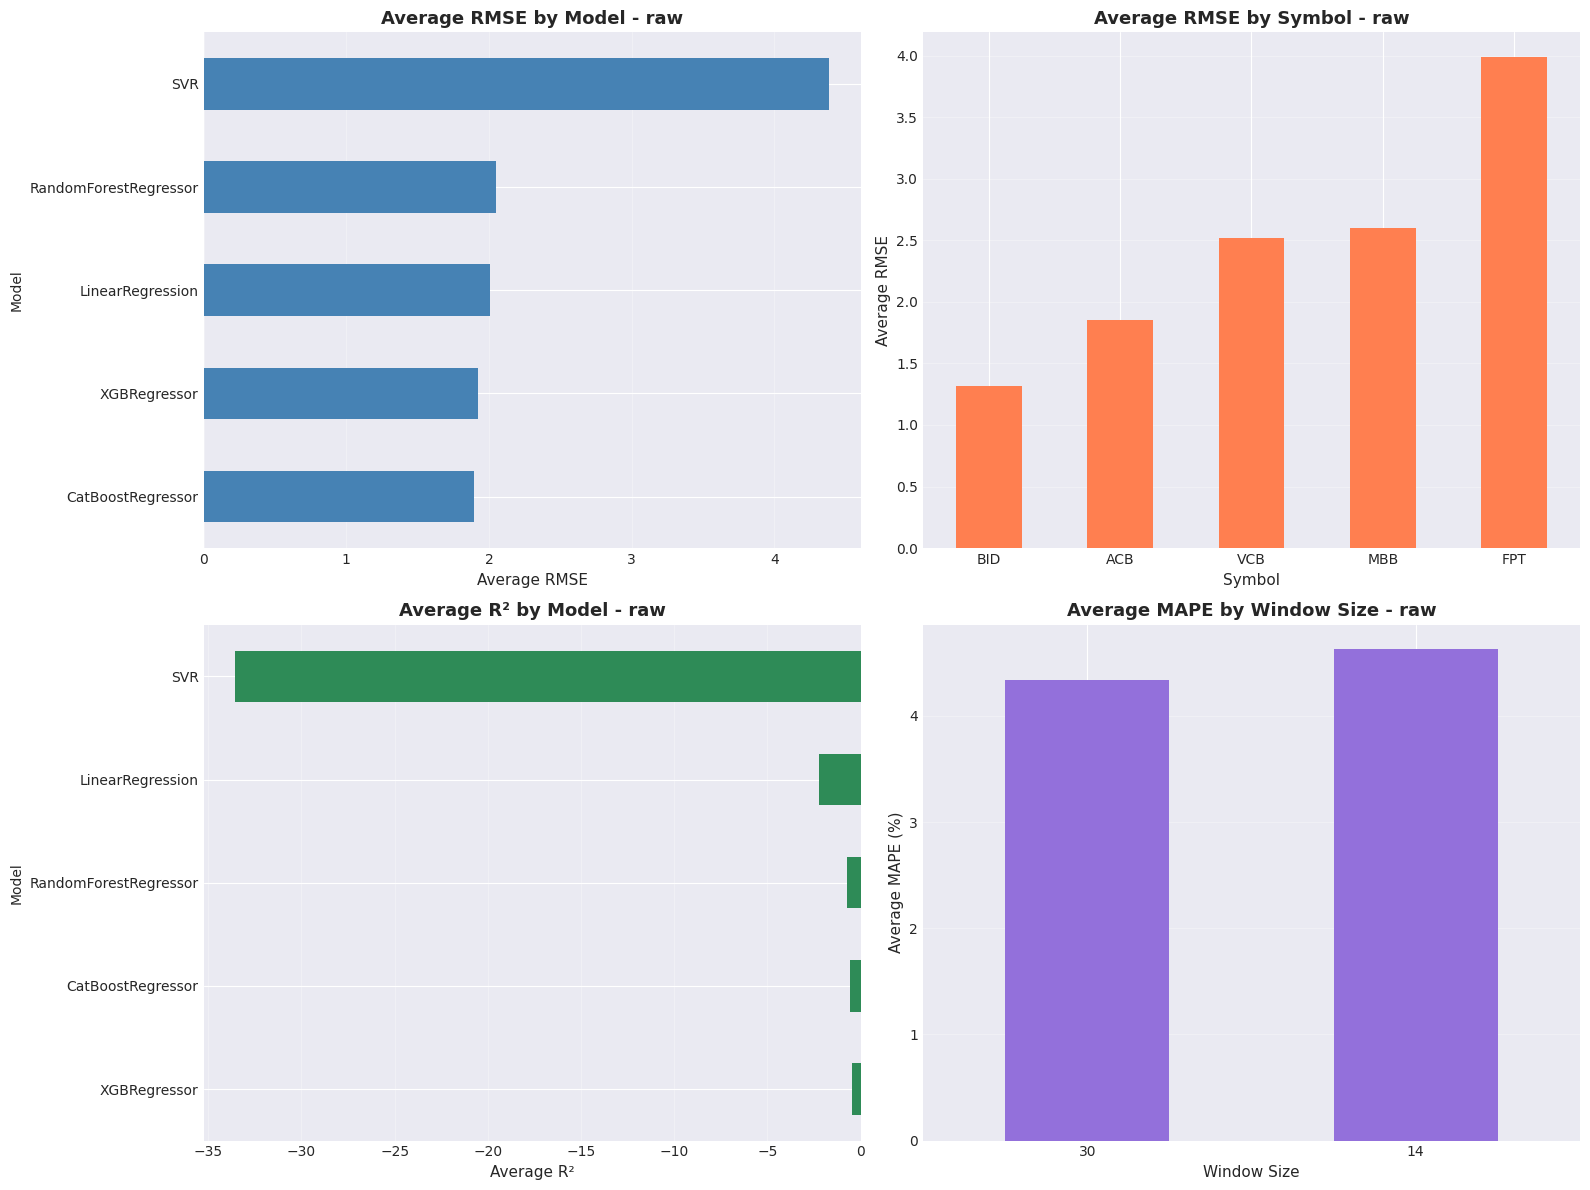


📊 ANALYSIS: WITH_INDICATORS Dataset

1️⃣ Overall Statistics:
   Total Experiments: 50
   Symbols: ['ACB', 'BID', 'VCB', 'MBB', 'FPT']
   Models: ['LinearRegression', 'RandomForestRegressor', 'XGBRegressor', 'CatBoostRegressor', 'SVR']
   Window Sizes: [14, 30]

2️⃣ Best Models (by RMSE):
Symbol                 Model  Window_Size     RMSE      MAE        R2
   MBB          XGBRegressor           30 0.709862 0.541169 -0.109723
   MBB     CatBoostRegressor           14 0.791575 0.697383 -0.379912
   MBB          XGBRegressor           14 0.791673 0.645400 -0.380252
   MBB     CatBoostRegressor           30 0.811544 0.714602 -0.450411
   MBB RandomForestRegressor           14 0.976891 0.740565 -1.101643
   MBB RandomForestRegressor           30 1.057829 0.814073 -1.464326
   ACB     CatBoostRegressor           30 1.059720 0.919455 -0.012366
   BID      LinearRegression           30 1.066364 0.785201 -0.079416
   BID      LinearRegression           14 1.082743 0.778191 -0.112830
   BID Ran

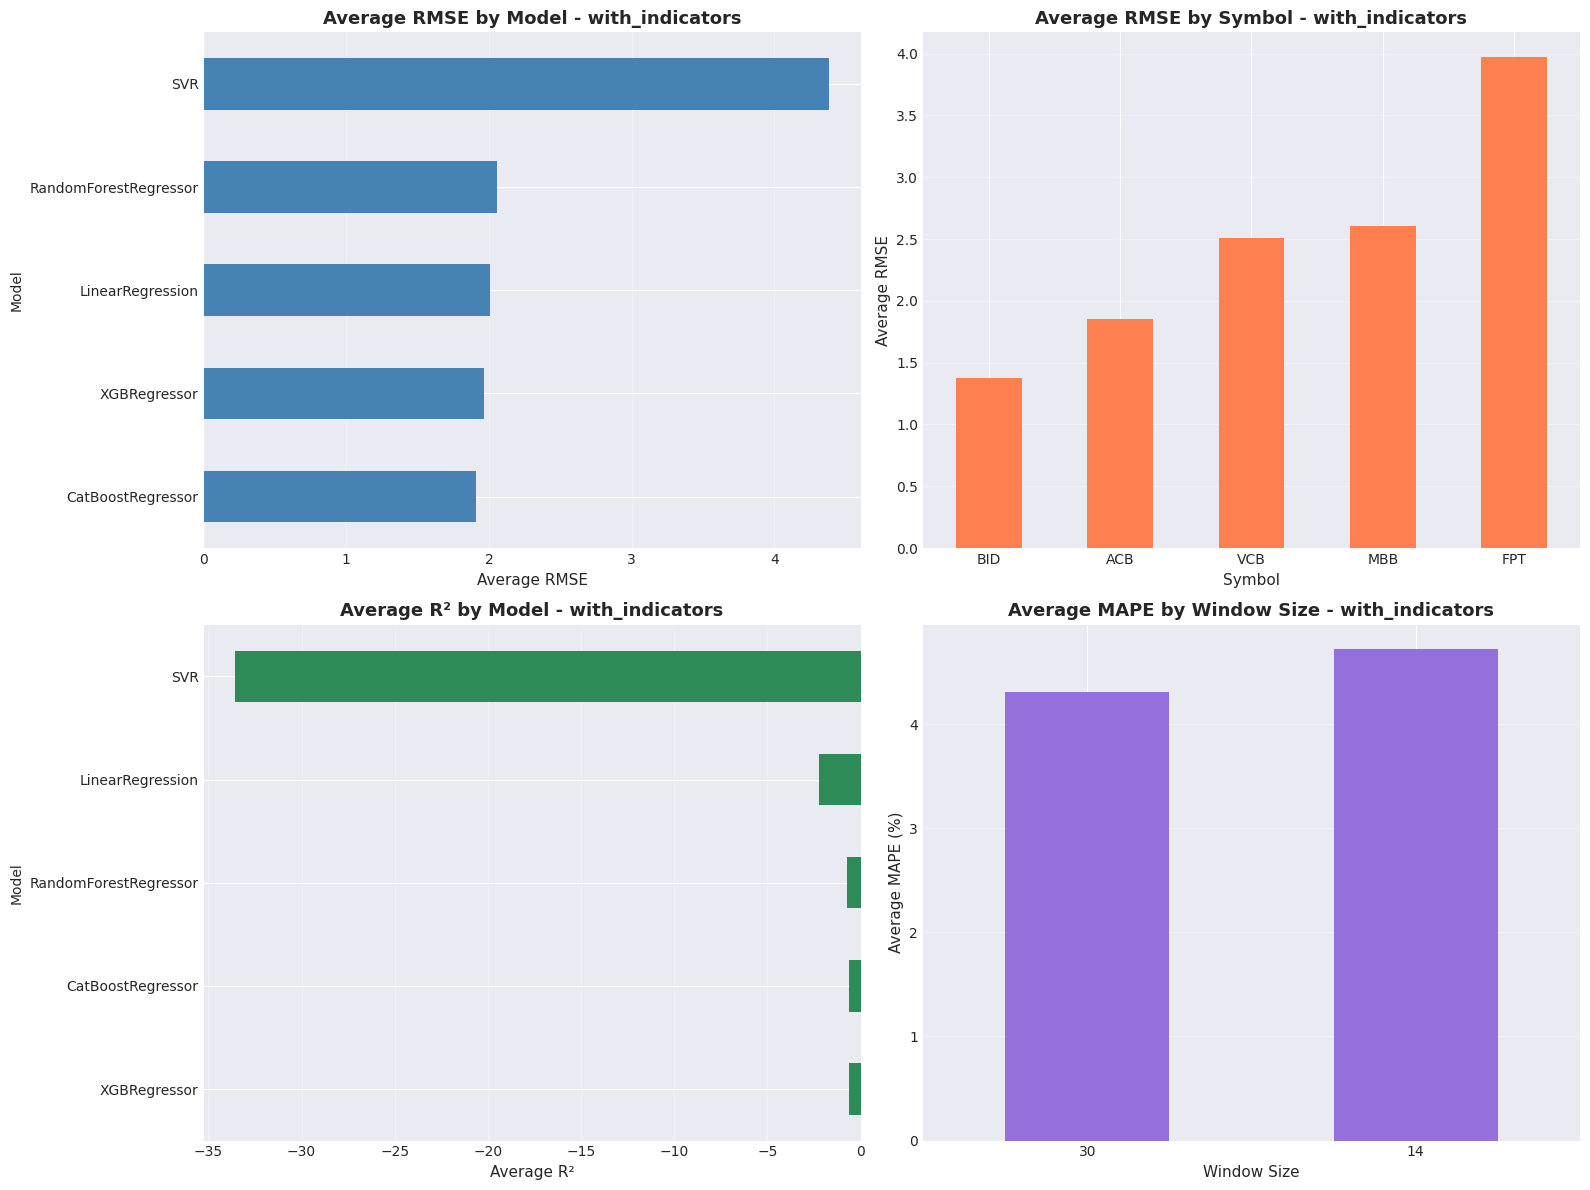

In [11]:
def analyze_results(results_df, dataset_name):
    """Analyze and visualize Rolling Window results"""
    
    if len(results_df) == 0:
        print("No results to analyze!")
        return
    
    print(f"\n{'='*70}")
    print(f"📊 ANALYSIS: {dataset_name.upper()} Dataset")
    print(f"{'='*70}")
    
    # 1. Overall Statistics
    print(f"\n1️⃣ Overall Statistics:")
    print(f"   Total Experiments: {len(results_df)}")
    print(f"   Symbols: {results_df['Symbol'].unique().tolist()}")
    print(f"   Models: {results_df['Model'].unique().tolist()}")
    print(f"   Window Sizes: {sorted(results_df['Window_Size'].unique().tolist())}")
    
    # 2. Best Models by Metric
    print(f"\n2️⃣ Best Models (by RMSE):")
    top_models = results_df.nsmallest(10, 'RMSE')[
        ['Symbol', 'Model', 'Window_Size', 'RMSE', 'MAE', 'R2']
    ]
    print(top_models.to_string(index=False))
    
    # 3. Best Model per Symbol
    print(f"\n3️⃣ Best Model per Symbol:")
    for symbol in results_df['Symbol'].unique():
        symbol_data = results_df[results_df['Symbol'] == symbol]
        best = symbol_data.nsmallest(1, 'RMSE').iloc[0]
        print(f"   {symbol}: {best['Model']:<25} W:{best['Window_Size']} | "
              f"RMSE={best['RMSE']:.4f} | MAE={best['MAE']:.4f} | "
              f"R²={best['R2']:.4f}")
    
    # 4. Average Performance by Model
    print(f"\n4️⃣ Average Performance by Model:")
    model_avg = results_df.groupby('Model').agg({
        'RMSE': 'mean',
        'MAE': 'mean',
        'MAPE': 'mean',
        'R2': 'mean'
    }).round(4).sort_values('RMSE')
    print(model_avg)
    
    # 5. Window Size Analysis
    print(f"\n5️⃣ Average Performance by Window Size:")
    window_avg = results_df.groupby('Window_Size').agg({
        'RMSE': 'mean',
        'MAE': 'mean',
        'MAPE': 'mean',
        'R2': 'mean'
    }).round(4).sort_values('RMSE')
    print(window_avg)
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: RMSE by Model
    ax1 = axes[0, 0]
    model_rmse = results_df.groupby('Model')['RMSE'].mean().sort_values()
    model_rmse.plot(kind='barh', ax=ax1, color='steelblue')
    ax1.set_xlabel('Average RMSE', fontsize=11)
    ax1.set_title(f'Average RMSE by Model - {dataset_name}', fontsize=13, weight='bold')
    ax1.grid(axis='x', alpha=0.3)
    
    # Plot 2: RMSE by Symbol
    ax2 = axes[0, 1]
    symbol_rmse = results_df.groupby('Symbol')['RMSE'].mean().sort_values()
    symbol_rmse.plot(kind='bar', ax=ax2, color='coral')
    ax2.set_xlabel('Symbol', fontsize=11)
    ax2.set_ylabel('Average RMSE', fontsize=11)
    ax2.set_title(f'Average RMSE by Symbol - {dataset_name}', fontsize=13, weight='bold')
    ax2.grid(axis='y', alpha=0.3)
    ax2.tick_params(axis='x', rotation=0)
    
    # Plot 3: R² by Model
    ax3 = axes[1, 0]
    model_r2 = results_df.groupby('Model')['R2'].mean().sort_values(ascending=False)
    model_r2.plot(kind='barh', ax=ax3, color='seagreen')
    ax3.set_xlabel('Average R²', fontsize=11)
    ax3.set_title(f'Average R² by Model - {dataset_name}', fontsize=13, weight='bold')
    ax3.grid(axis='x', alpha=0.3)
    
    # Plot 4: MAPE by Window Size
    ax4 = axes[1, 1]
    window_mape = results_df.groupby('Window_Size')['MAPE'].mean().sort_values()
    window_mape.plot(kind='bar', ax=ax4, color='mediumpurple')
    ax4.set_xlabel('Window Size', fontsize=11)
    ax4.set_ylabel('Average MAPE (%)', fontsize=11)
    ax4.set_title(f'Average MAPE by Window Size - {dataset_name}', fontsize=13, weight='bold')
    ax4.grid(axis='y', alpha=0.3)
    ax4.tick_params(axis='x', rotation=0)
    
    plt.tight_layout()
    
    # Save figure
    fig_path = output_dir / f"rolling_window_analysis_{dataset_name}.png"
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"\n💾 Analysis plot saved: {fig_path}")
    
    plt.show()
    
    return model_avg, window_avg


# Analyze results if available
if 'results_raw' in locals() and len(results_raw) > 0:
    model_stats_raw, window_stats_raw = analyze_results(results_raw, 'raw')

if 'results_ind' in locals() and len(results_ind) > 0:
    model_stats_ind, window_stats_ind = analyze_results(results_ind, 'with_indicators')

## 📈 7.5 Visualize Forecasting Results

Visualize the 30-day forecasts for each symbol with the best model.

In [13]:
def visualize_test_forecasts(df, results_df, dataset_name, symbols=None, top_n=3):
    """
    Visualize the 30-day test forecasts for best models
    
    Args:
        df: DataFrame with stock data
        results_df: Results DataFrame from training
        dataset_name: Name of dataset
        symbols: List of symbols to visualize (None = all)
        top_n: Number of top models to show per symbol
    """
    if symbols is None:
        symbols = results_df['Symbol'].unique()
    
    for symbol in symbols:
        print(f"\n{'='*70}")
        print(f"📈 FORECASTING VISUALIZATION: {symbol} ({dataset_name})")
        print(f"{'='*70}")
        
        # Get best models for this symbol
        symbol_results = results_df[results_df['Symbol'] == symbol].nsmallest(top_n, 'RMSE')
        
        if len(symbol_results) == 0:
            print(f"No results found for {symbol}")
            continue
        
        # Create figure with subplots
        n_models = len(symbol_results)
        fig, axes = plt.subplots(n_models, 1, figsize=(16, 5*n_models))
        
        if n_models == 1:
            axes = [axes]
        
        for idx, (_, row) in enumerate(symbol_results.iterrows()):
            ax = axes[idx]
            
            # Re-run training to get predictions (since we didn't store them)
            model_name = row['Model']
            window_size = row['Window_Size']
            test_days = row['Test_Days']
            
            print(f"\n🔄 Generating forecast for {model_name} (Window={window_size})...")
            
            # Get the model
            model = ML_MODELS[model_name]
            
            # Run training
            result = train_and_forecast_rolling_window(
                df=df,
                symbol=symbol,
                model_name=model_name,
                model=model,
                window_size=window_size,
                test_days=test_days,
                dataset_name=dataset_name,
                use_scaling=True
            )
            
            # Extract data
            predictions = result['predictions']
            actuals = result['actuals']
            train_data = result['train_data']
            dates = pd.to_datetime(result['dates'])
            split_index = result['split_index']
            
            # Dates for train, test
            train_dates = dates[:split_index]
            test_dates = dates[split_index:]
            
            # Plot historical (last 60 days of training)
            lookback = min(60, len(train_data))
            ax.plot(train_dates[-lookback:], train_data[-lookback:], 
                   'o-', linewidth=1.5, markersize=3, label='Historical (Train)', 
                   color='steelblue', alpha=0.7)
            
            # Plot actual test data
            ax.plot(test_dates, actuals, 
                   'o-', linewidth=2, markersize=4, label='Actual (Test)', 
                   color='darkgreen', alpha=0.9)
            
            # Plot predictions
            ax.plot(test_dates, predictions, 
                   'o--', linewidth=2, markersize=4, label='Forecast', 
                   color='coral', alpha=0.9)
            
            # Add vertical line at split
            ax.axvline(x=test_dates[0], color='red', linestyle='--', 
                      linewidth=2, alpha=0.5, label='Train-Test Split')
            
            # Metrics text
            metrics_text = (f"RMSE: {row['RMSE']:.4f} | "
                          f"MAE: {row['MAE']:.4f} | "
                          f"MAPE: {row['MAPE']:.2f}% | "
                          f"R²: {row['R2']:.4f}")
            
            # Title
            ax.set_title(f"{symbol} - {model_name} (Window={window_size})\n{metrics_text}", 
                        fontsize=13, weight='bold')
            ax.set_xlabel('Date', fontsize=11, weight='bold')
            ax.set_ylabel('Price', fontsize=11, weight='bold')
            ax.legend(loc='best', fontsize=10)
            ax.grid(True, alpha=0.3)
            
            # Rotate x labels
            ax.tick_params(axis='x', rotation=45)
            
            print(f"   ✅ RMSE: {row['RMSE']:.4f} | MAE: {row['MAE']:.4f}")
        
        plt.tight_layout()
        
        # Save figure
        fig_path = output_dir / f"forecast_test_{symbol}_{dataset_name}_top{top_n}.png"
        plt.savefig(fig_path, dpi=300, bbox_inches='tight')
        print(f"\n💾 Forecast plot saved: {fig_path}")
        
        plt.show()


print("✅ Visualization function defined!")
print("\n📋 Function: visualize_test_forecasts()")
print("   - Shows actual vs predicted for 30-day test period")
print("   - Displays top N models per symbol")
print("   - Includes historical context")

✅ Visualization function defined!

📋 Function: visualize_test_forecasts()
   - Shows actual vs predicted for 30-day test period
   - Displays top N models per symbol
   - Includes historical context



📊 VISUALIZING 30-DAY TEST FORECASTS - RAW DATASET

📈 FORECASTING VISUALIZATION: ACB (raw)

🔄 Generating forecast for CatBoostRegressor (Window=30)...
   ✅ RMSE: 1.0580 | MAE: 0.9149
   ✅ RMSE: 1.0580 | MAE: 0.9149

💾 Forecast plot saved: /mnt/d/Ky 4/financial-news-sentiment-main/Source/recode/Machine_learning/results_rolling_window/forecast_test_ACB_raw_top1.png

💾 Forecast plot saved: /mnt/d/Ky 4/financial-news-sentiment-main/Source/recode/Machine_learning/results_rolling_window/forecast_test_ACB_raw_top1.png


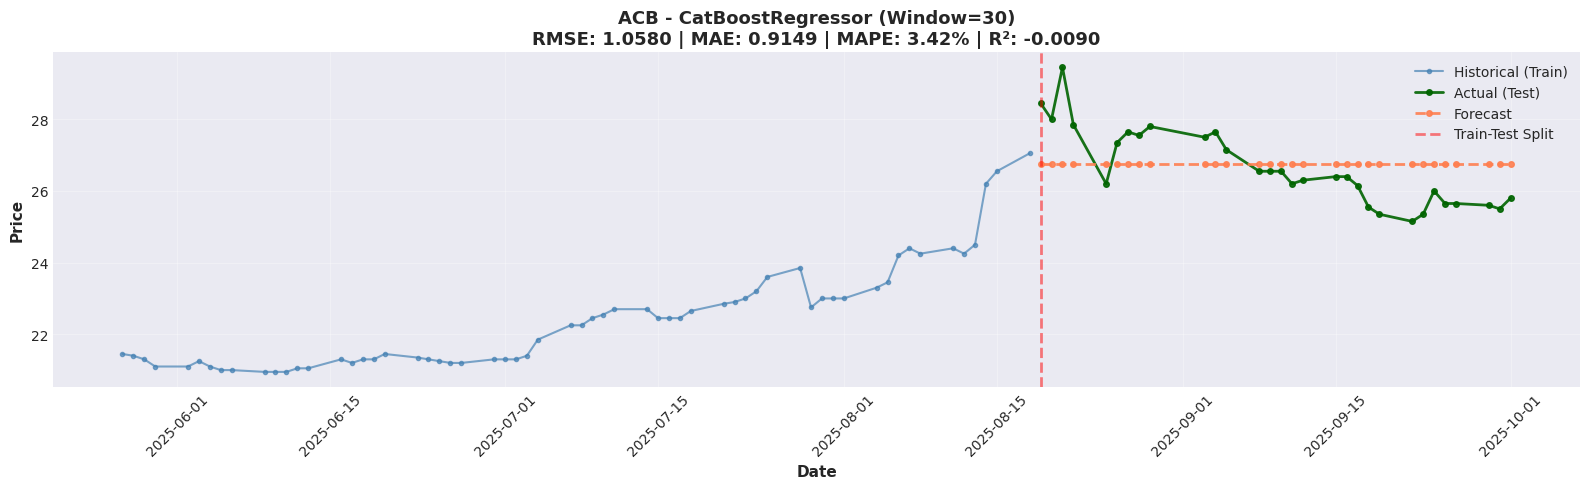


📈 FORECASTING VISUALIZATION: BID (raw)

🔄 Generating forecast for LinearRegression (Window=30)...
   ✅ RMSE: 1.0666 | MAE: 0.7845

💾 Forecast plot saved: /mnt/d/Ky 4/financial-news-sentiment-main/Source/recode/Machine_learning/results_rolling_window/forecast_test_BID_raw_top1.png

💾 Forecast plot saved: /mnt/d/Ky 4/financial-news-sentiment-main/Source/recode/Machine_learning/results_rolling_window/forecast_test_BID_raw_top1.png


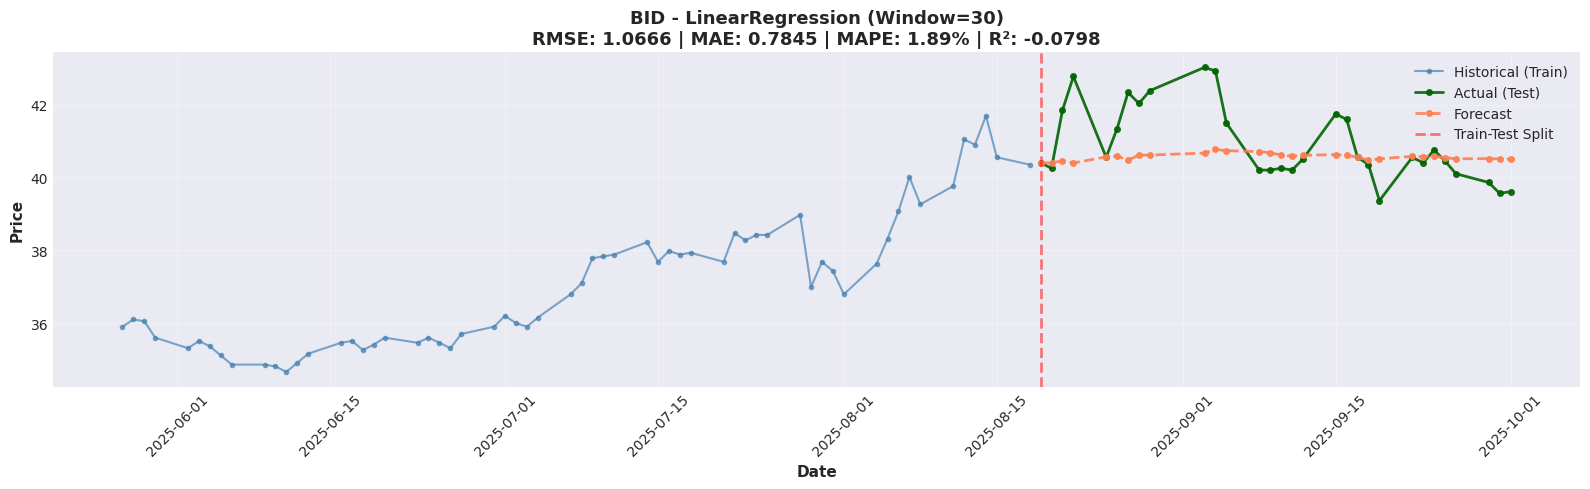


📈 FORECASTING VISUALIZATION: VCB (raw)

🔄 Generating forecast for XGBRegressor (Window=30)...
   ✅ RMSE: 2.0734 | MAE: 1.5193
   ✅ RMSE: 2.0734 | MAE: 1.5193

💾 Forecast plot saved: /mnt/d/Ky 4/financial-news-sentiment-main/Source/recode/Machine_learning/results_rolling_window/forecast_test_VCB_raw_top1.png

💾 Forecast plot saved: /mnt/d/Ky 4/financial-news-sentiment-main/Source/recode/Machine_learning/results_rolling_window/forecast_test_VCB_raw_top1.png


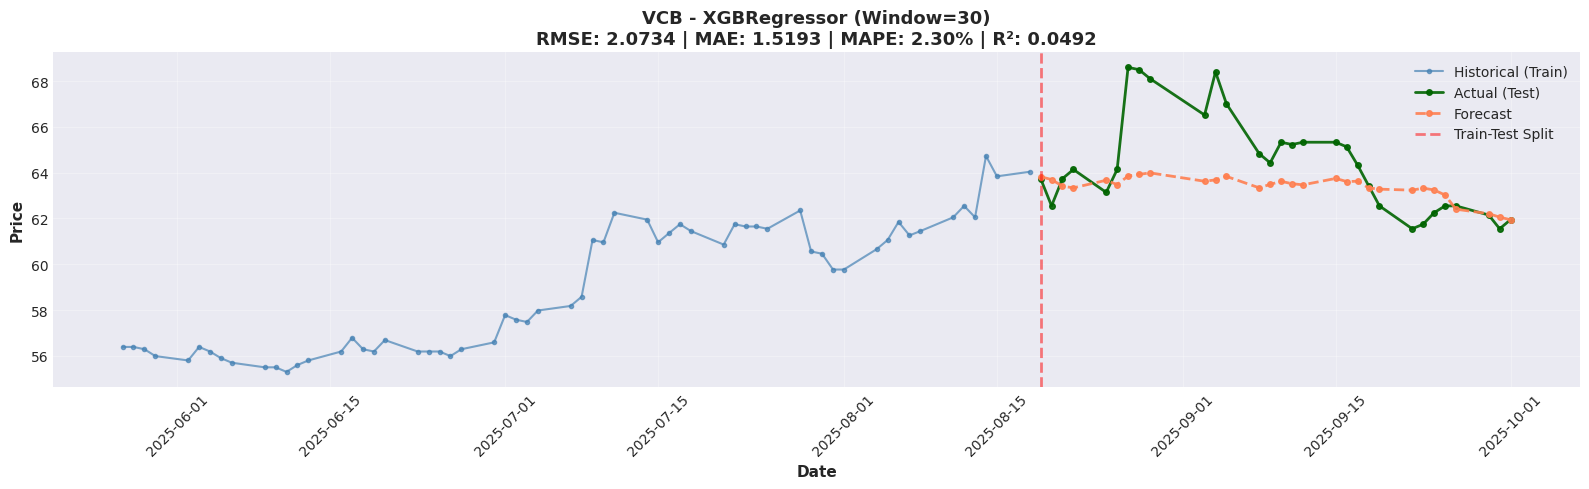


📈 FORECASTING VISUALIZATION: MBB (raw)

🔄 Generating forecast for XGBRegressor (Window=30)...
   ✅ RMSE: 0.6740 | MAE: 0.5385
   ✅ RMSE: 0.6740 | MAE: 0.5385

💾 Forecast plot saved: /mnt/d/Ky 4/financial-news-sentiment-main/Source/recode/Machine_learning/results_rolling_window/forecast_test_MBB_raw_top1.png

💾 Forecast plot saved: /mnt/d/Ky 4/financial-news-sentiment-main/Source/recode/Machine_learning/results_rolling_window/forecast_test_MBB_raw_top1.png


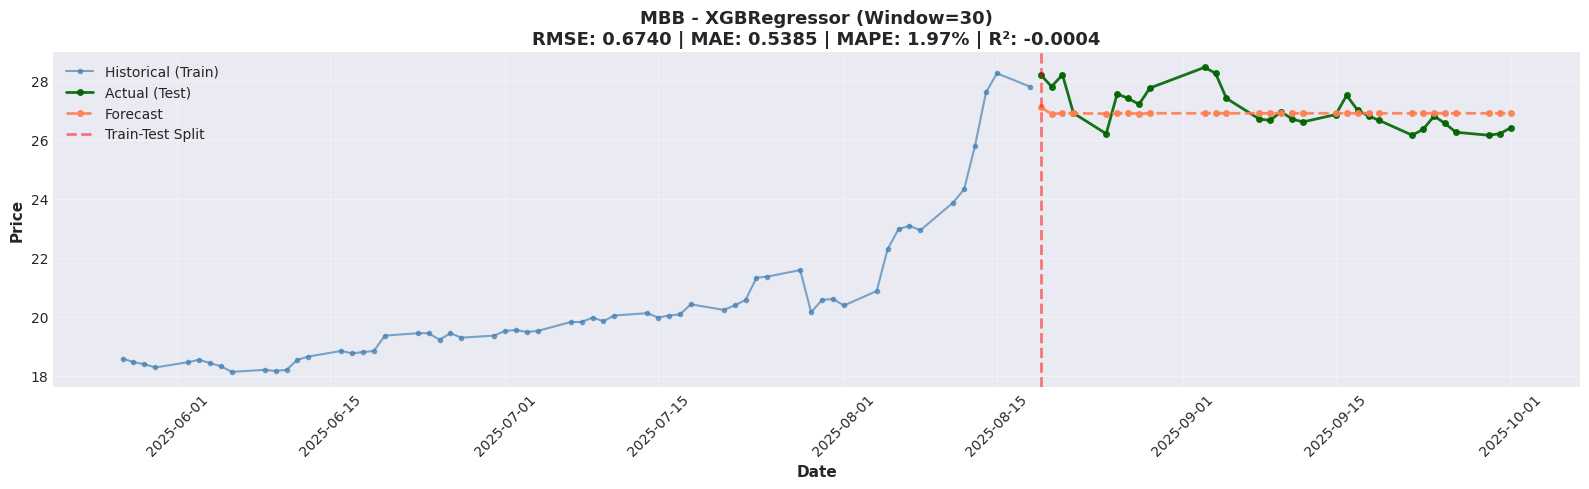


📈 FORECASTING VISUALIZATION: FPT (raw)

🔄 Generating forecast for CatBoostRegressor (Window=14)...
   ✅ RMSE: 3.1572 | MAE: 2.7126
   ✅ RMSE: 3.1572 | MAE: 2.7126

💾 Forecast plot saved: /mnt/d/Ky 4/financial-news-sentiment-main/Source/recode/Machine_learning/results_rolling_window/forecast_test_FPT_raw_top1.png

💾 Forecast plot saved: /mnt/d/Ky 4/financial-news-sentiment-main/Source/recode/Machine_learning/results_rolling_window/forecast_test_FPT_raw_top1.png


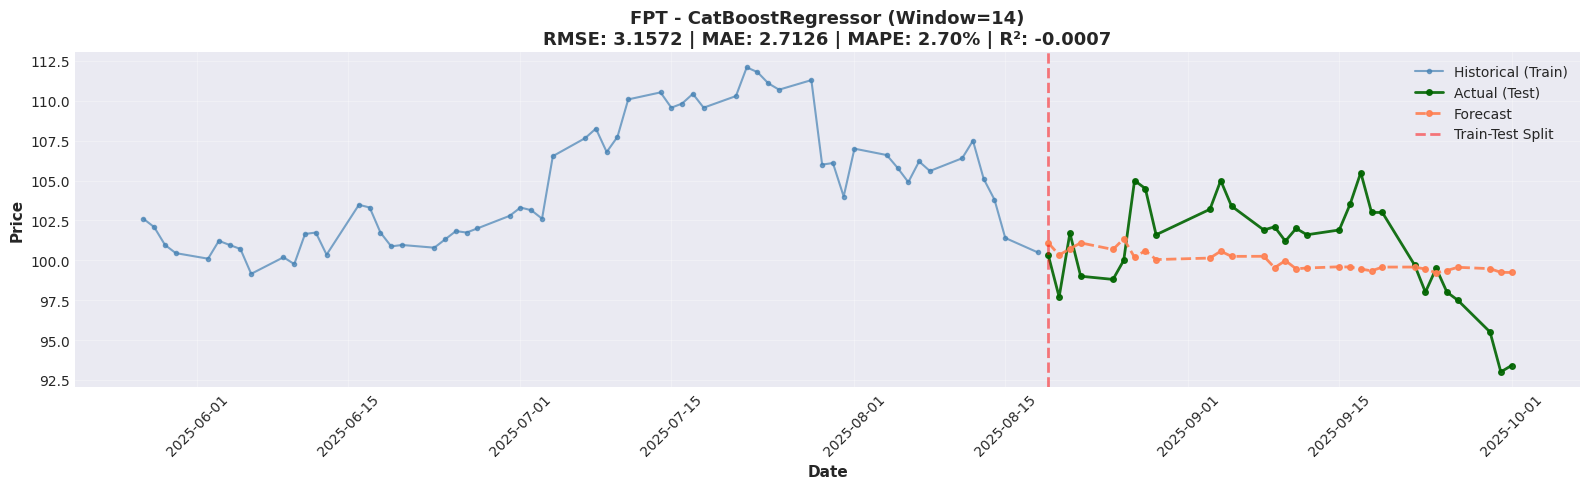

In [14]:
# Visualize forecasts for RAW dataset
if 'results_raw' in locals() and len(results_raw) > 0:
    print("\n" + "="*70)
    print("📊 VISUALIZING 30-DAY TEST FORECASTS - RAW DATASET")
    print("="*70)
    
    # Show forecasts for all symbols with best model each
    visualize_test_forecasts(
        df=df_raw,
        results_df=results_raw,
        dataset_name='raw',
        symbols=SYMBOLS,  # All symbols
        top_n=1  # Best model only for each symbol
    )


📊 VISUALIZING 30-DAY TEST FORECASTS - WITH INDICATORS DATASET

📈 FORECASTING VISUALIZATION: ACB (with_indicators)

🔄 Generating forecast for CatBoostRegressor (Window=30)...
   ✅ RMSE: 1.0597 | MAE: 0.9195
   ✅ RMSE: 1.0597 | MAE: 0.9195

💾 Forecast plot saved: /mnt/d/Ky 4/financial-news-sentiment-main/Source/recode/Machine_learning/results_rolling_window/forecast_test_ACB_with_indicators_top1.png

💾 Forecast plot saved: /mnt/d/Ky 4/financial-news-sentiment-main/Source/recode/Machine_learning/results_rolling_window/forecast_test_ACB_with_indicators_top1.png


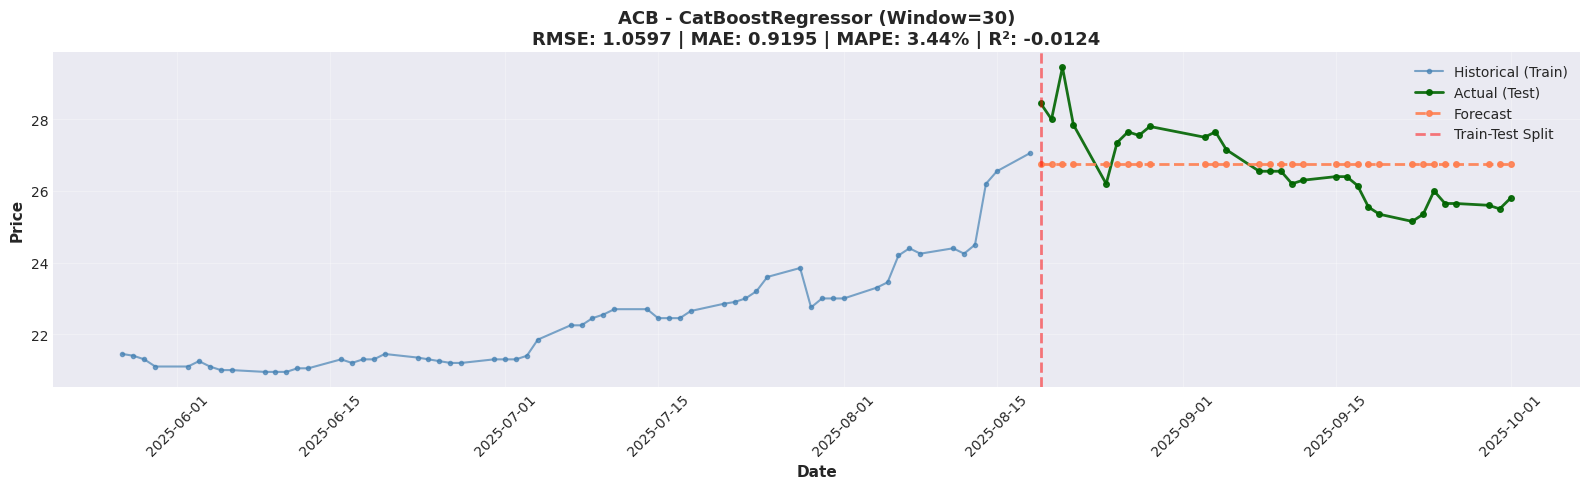


📈 FORECASTING VISUALIZATION: BID (with_indicators)

🔄 Generating forecast for LinearRegression (Window=30)...
   ✅ RMSE: 1.0664 | MAE: 0.7852

💾 Forecast plot saved: /mnt/d/Ky 4/financial-news-sentiment-main/Source/recode/Machine_learning/results_rolling_window/forecast_test_BID_with_indicators_top1.png

💾 Forecast plot saved: /mnt/d/Ky 4/financial-news-sentiment-main/Source/recode/Machine_learning/results_rolling_window/forecast_test_BID_with_indicators_top1.png


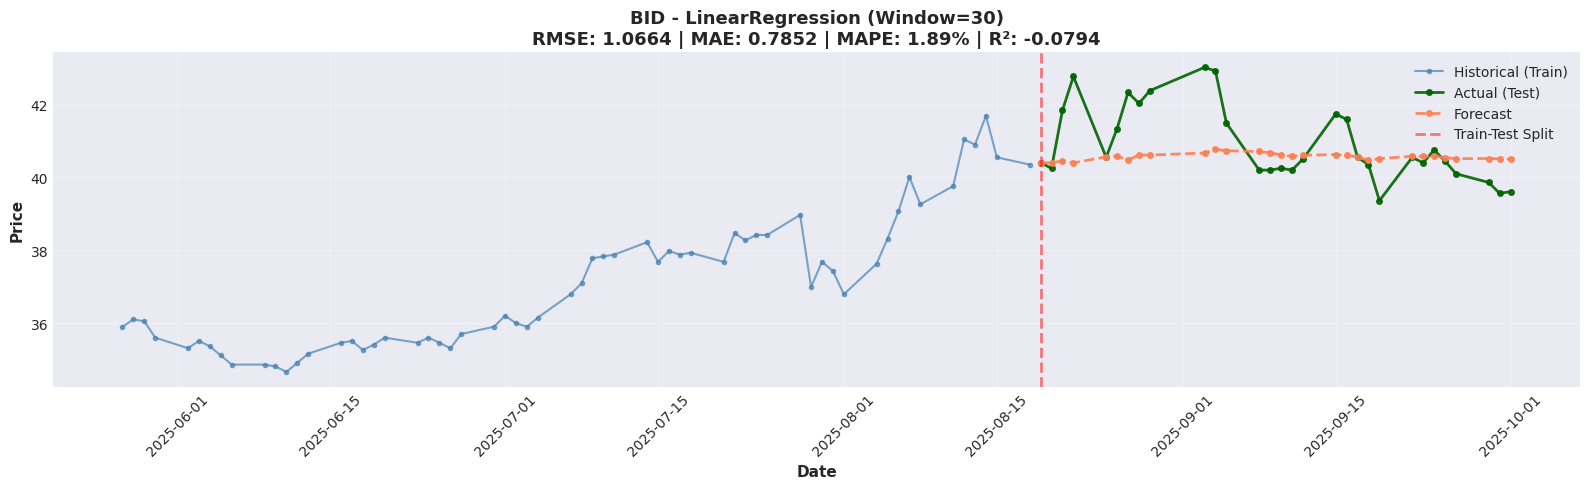


📈 FORECASTING VISUALIZATION: VCB (with_indicators)

🔄 Generating forecast for CatBoostRegressor (Window=30)...
   ✅ RMSE: 1.9354 | MAE: 1.3299
   ✅ RMSE: 1.9354 | MAE: 1.3299

💾 Forecast plot saved: /mnt/d/Ky 4/financial-news-sentiment-main/Source/recode/Machine_learning/results_rolling_window/forecast_test_VCB_with_indicators_top1.png

💾 Forecast plot saved: /mnt/d/Ky 4/financial-news-sentiment-main/Source/recode/Machine_learning/results_rolling_window/forecast_test_VCB_with_indicators_top1.png


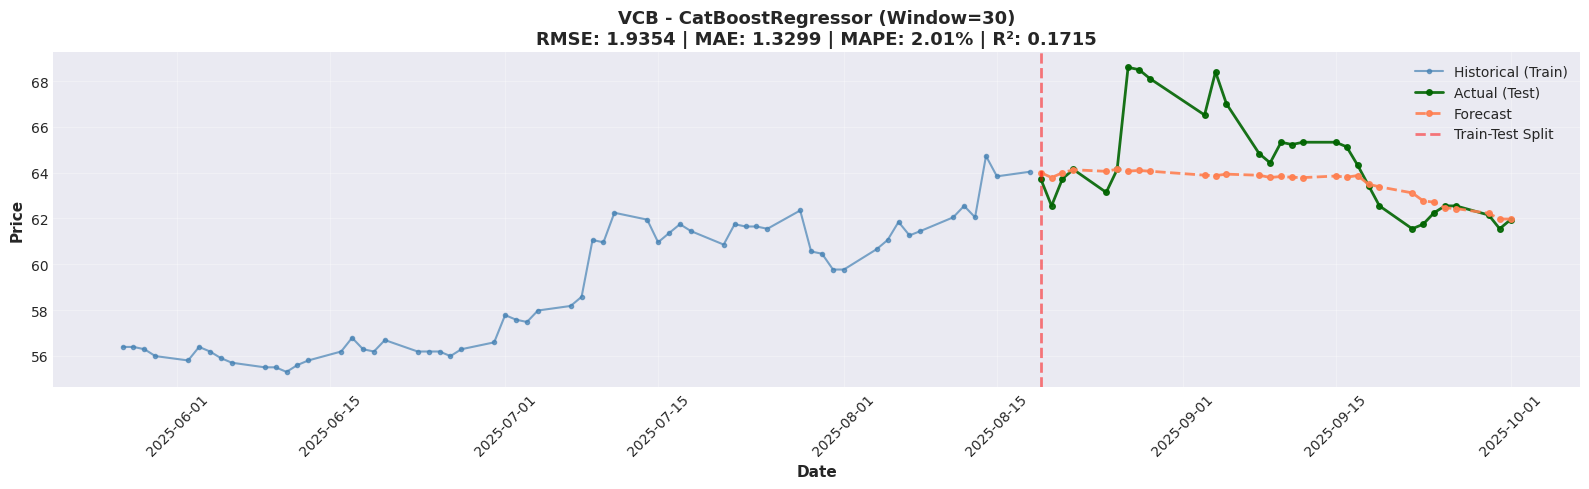


📈 FORECASTING VISUALIZATION: MBB (with_indicators)

🔄 Generating forecast for XGBRegressor (Window=30)...
   ✅ RMSE: 0.7099 | MAE: 0.5412
   ✅ RMSE: 0.7099 | MAE: 0.5412

💾 Forecast plot saved: /mnt/d/Ky 4/financial-news-sentiment-main/Source/recode/Machine_learning/results_rolling_window/forecast_test_MBB_with_indicators_top1.png

💾 Forecast plot saved: /mnt/d/Ky 4/financial-news-sentiment-main/Source/recode/Machine_learning/results_rolling_window/forecast_test_MBB_with_indicators_top1.png


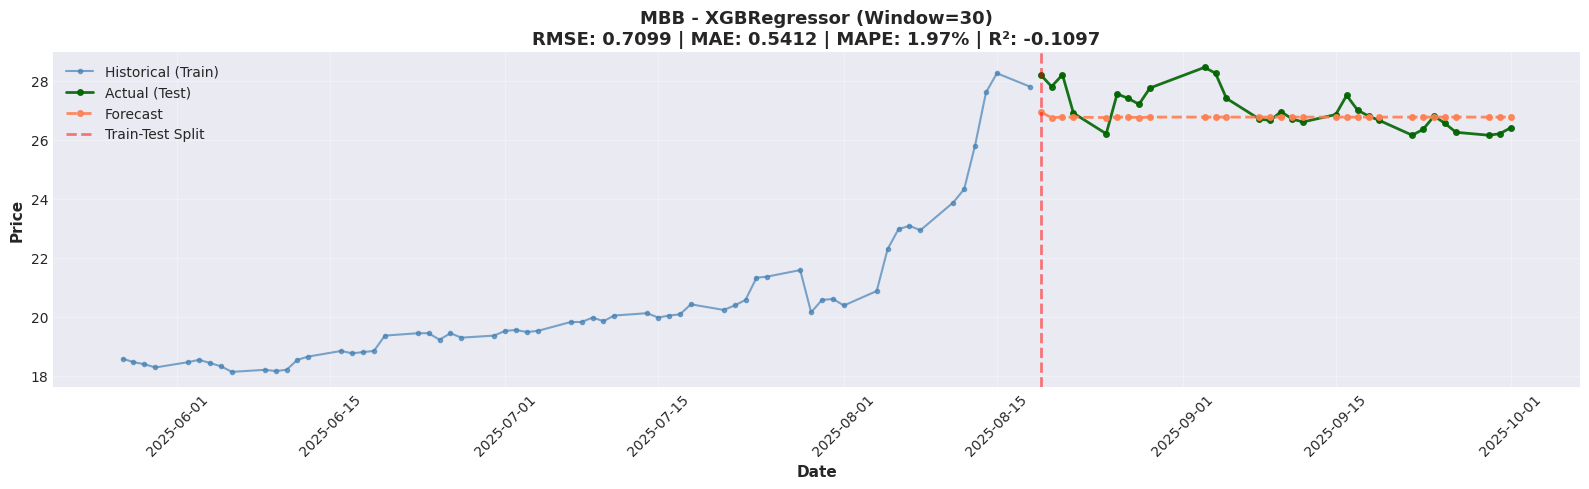


📈 FORECASTING VISUALIZATION: FPT (with_indicators)

🔄 Generating forecast for XGBRegressor (Window=14)...
   ✅ RMSE: 3.2758 | MAE: 2.6622
   ✅ RMSE: 3.2758 | MAE: 2.6622

💾 Forecast plot saved: /mnt/d/Ky 4/financial-news-sentiment-main/Source/recode/Machine_learning/results_rolling_window/forecast_test_FPT_with_indicators_top1.png

💾 Forecast plot saved: /mnt/d/Ky 4/financial-news-sentiment-main/Source/recode/Machine_learning/results_rolling_window/forecast_test_FPT_with_indicators_top1.png


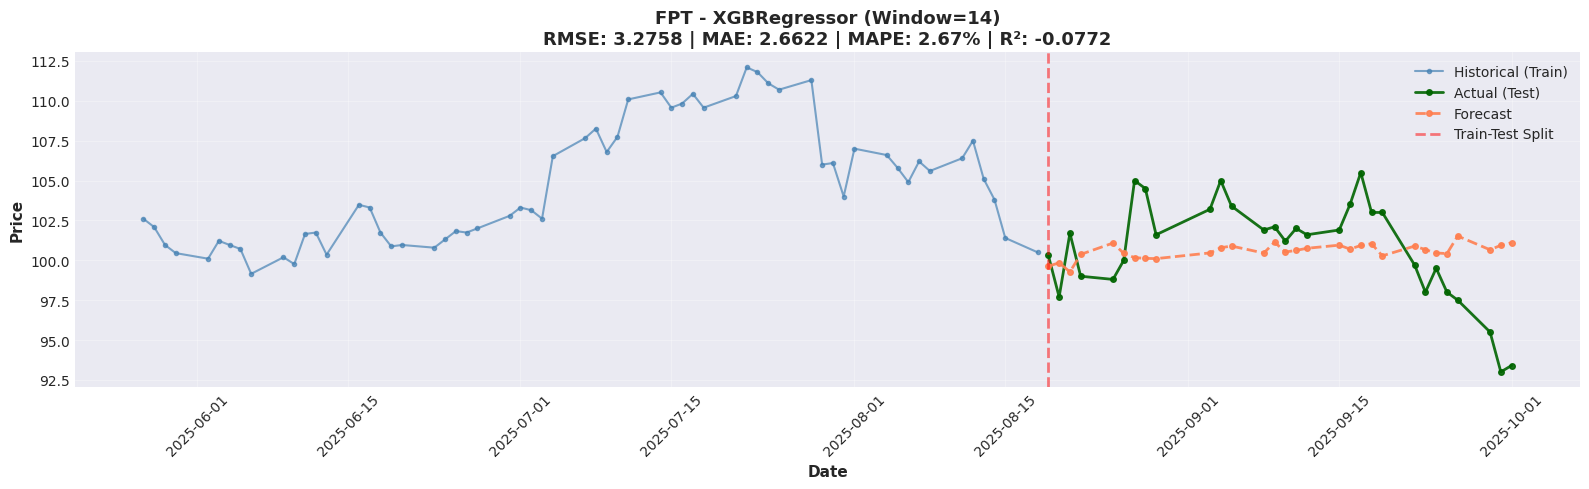

In [15]:
# Visualize forecasts for WITH INDICATORS dataset
if 'results_ind' in locals() and len(results_ind) > 0:
    print("\n" + "="*70)
    print("📊 VISUALIZING 30-DAY TEST FORECASTS - WITH INDICATORS DATASET")
    print("="*70)
    
    # Show forecasts for all symbols with best model each
    visualize_test_forecasts(
        df=df_ind,
        results_df=results_ind,
        dataset_name='with_indicators',
        symbols=SYMBOLS,  # All symbols
        top_n=1  # Best model only for each symbol
    )

## 📋 Summary: Data Leakage Prevention Strategy

### ✅ How We Prevent Data Leakage

**1. Clean Train-Test Split**
```python
Training Data: Day 1 → Day N-30  (~9+ years)
Test Data:     Day N-29 → Day N  (last 30 days)
                         ↑
                    HARD BOUNDARY
                    No Overlap
```

**2. Rolling Window ONLY on Training Data**
```python
# Within training data only
for i in range(len(train_data) - window_size):
    X[i] = train_data[i : i+window_size]     # Past 14/30 days
    y[i] = train_data[i+window_size]         # Next day
```

**3. Recursive Forecasting for Test**
```python
# Start from last training window
initial_window = train_data[-window_size:]

# Predict step by step, using predictions as input
for each test day:
    prediction = model.predict(current_window)
    current_window = roll(current_window, prediction)
```

### 🔒 Data Leakage Checklist

✅ **Test data completely isolated** - Never used in training  
✅ **Rolling window within training** - Only past data used  
✅ **No future peeking** - Model can't see test data during training  
✅ **Recursive forecasting** - Realistic multi-step prediction  
✅ **Temporal order maintained** - Train always before test  
✅ **Visualizations verify** - Clear boundary between train/test

### 📊 Key Differences from Original Approach

| Aspect | Old (Walk Forward CV) | New (Rolling Window) |
|--------|----------------------|----------------------|
| **Test Split** | Multiple small test windows | Single 30-day test period |
| **Training** | Varies per fold | Fixed: all except last 30 days |
| **Validation** | Cross-validation | Single holdout test |
| **Realism** | Multiple scenarios | One realistic forecast |
| **Data Leakage Risk** | Low (if done correctly) | **Minimal (simpler)** |

### 🎯 Why This Approach?

1. **Simplicity**: Easier to understand and verify no leakage
2. **Realism**: Mirrors real-world forecasting (train on all past, predict future)
3. **Clear Boundary**: Obvious split point makes leakage prevention straightforward
4. **Long Training**: ~9 years of training data = robust models

## 🔮 8. Forecasting Future Values

Use the best model to forecast future stock prices.